## Python Project WhiteBoard
- [PDF Instructions](./PPES-SoSe2024_StudentProject.pdf)
- [Github Repository](https://github.com/boujuan)
---
**DATA:**
- Floating Lidar Measurements from two positions = 'data/measurements/*.nc'
- Long-term reference model data (ERA5): 1990-2023 = 'data/reanalysis/*.csv'
- Turbine coordinates of existing wind farms = 'data/turbine-info/coordinates/existing/*.csv'
- Turbine coordinates of planned wind farms = 'data/turbine-info/coordinates/planned_future/*.csv'
- Turbine coordinates in operation before 2023 = 'data/turbine-info/coordinates/planned_in_operation_before_2030/*.csv'
- Turbine coordinates planned in netherlands = 'data/turbine-info/coordinates/planned_netherlands/*.csv'
- Geometric turbine coordinates for the areas of interest N-9.1/N-9.2/N-9.3 (not optimized – see Task 12) = 'data/turbine-info/coordinates/area_of_interest/*.csv'
- Shapefiles of wind farm areas, the countries Denmark, Germany and the Netherlands = 'data/shapefiles/.../*'
- Thrust and power curves of wind turbines = 'data/turbine-info/power_curves/*.csv'
---
**TASKS:**
1. Organize all input data, filter, and read them in in a proper way
2. Plot relevant quantities (e.g. histograms, windroses, spatial plots or maps, time series, scatterplots, etc.) of the input 
data and describe potential deficiencies (e.g. data gaps).
3. Do a long-term referencing with lidar measurements and model data (ERA5) using different MCP methods 


In [101]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [102]:
# Function to read and extract data from netcdf files
def read_netcdf(path):
    data = nc.Dataset(path, 'r')
    return data

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [103]:
# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

In [104]:
# Read lidar data
lidar_files = os.listdir(lidar_path)
lidar_files = [read_netcdf(lidar_path + file) for file in lidar_files]

In [105]:
# Print the variables of the subgroups of the groups
for subgroup in lidar_files[0]['/METEO_WLBZ_6'].groups.values():
    print(f"Subgroup: {subgroup.name}")
    # print(subgroup)
    # print("\n< VARIABLES >\n")
    for variable in subgroup.variables.values():
        print(variable.name)

Subgroup: Vaisala Weather Station
rain_accumulation
rain_duration
rain_intensity
hail_accumulation
hail_duration
hail_intensity
precipitation_count
air_temperature
relative_humidity
air_pressure
air_density
air_density_moist
PTH_count
wind_speed_average
wind_speed_min
wind_speed_max
wind_count
Subgroup: Airmar Weather Station
air_pressure
air_temperature
air_density
wind_speed_min
wind_speed_max
wind_speed_average
wind_from_direction
count


### Testing the max wind speed data from the two lidar stations

**From Buoy Meteo WLBZ 6:**
Vaisala Weather Station VS Airmar Weather Station

Max Wind Speed Data: [ 7.22  7.03  7.01 ... 15.3  12.86 11.87]


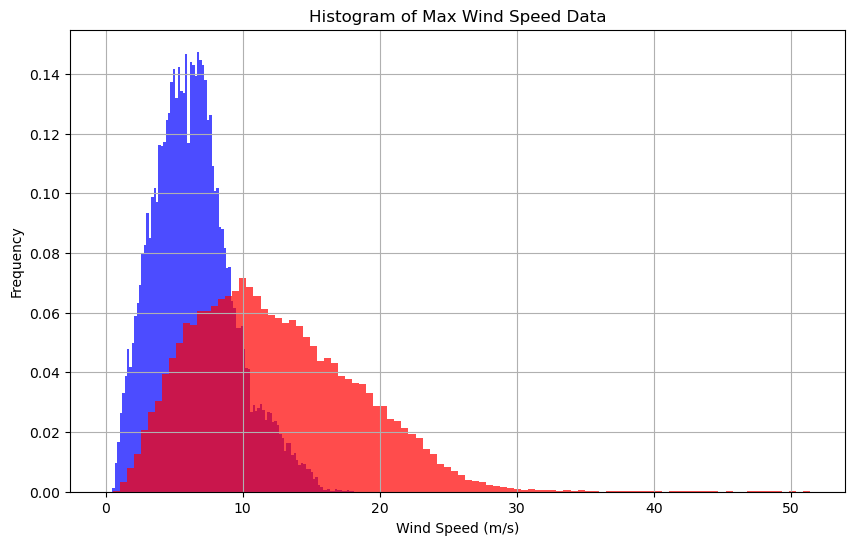

In [108]:
# Test extracting data from variables in groups of the netcdf file
x = lidar_files[0]['/METEO_WLBZ_6']['Vaisala Weather Station']['wind_speed_max'][:]
x2 = lidar_files[0]['/METEO_WLBZ_6']['Airmar Weather Station']['wind_speed_max'][:]

# Convert to numpy array, flatten the array, and filter out NaN values
x_clean = np.array(x).flatten()
x_clean = x_clean[~np.isnan(x_clean)]
x2_clean = np.array(x2).flatten()
x2_clean = x2_clean[~np.isnan(x2_clean)]

print("Max Wind Speed Data:", x_clean)

# Plot histogram of the max wind speed data frequency
fig1 = plt.figure(figsize=(10, 6))
plt.hist(x_clean, bins=100, color='blue', alpha=0.7, density=True)
plt.hist(x2_clean, bins=100, color='red', alpha=0.7, density=True)
plt.title("Histogram of Max Wind Speed Data")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()